In [274]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from statistics import mean
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_squared_log_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder

In [275]:
# DATAPATH = "/kaggle/input/store-sales-time-series-forecasting"
DATAPATH = "data/store-sales"
FIGSIZE = (14, 4)

In [276]:
train_df = pd.read_csv(DATAPATH + '/train.csv', parse_dates=['date'])
test_df = pd.read_csv(DATAPATH + '/test.csv', parse_dates=['date'])

stores_df = pd.read_csv(DATAPATH + '/stores.csv')
stores_df = stores_df.rename(columns={'type': 'store_type'})

transactions_df = pd.read_csv(DATAPATH + '/transactions.csv', parse_dates=['date'])
oil_df = pd.read_csv(DATAPATH + '/oil.csv', parse_dates=['date'])

holidays_df = pd.read_csv(DATAPATH + '/holidays_events.csv', parse_dates=['date'])

In [277]:
def remove_empty(df):
    # remove 0 sales
    return df


train_df = remove_empty(train_df)

In [278]:
def assign_time_ft(df):
    df['month_end'] = df['date'].dt.is_month_end.astype(int)
    df['payday'] = ((df['date'].dt.day == 15) | df['date'].dt.is_month_end).astype(int)
    df["weekofyear"] = df['date'].dt.isocalendar().week
    df['weekday'] = df['date'].dt.weekday
    df['day'] = df['date'].dt.day
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year

    df['is_weekday'] = 0
    df.loc[df['weekday'] < 5, 'is_weekday'] = 1

    df["season"] = df["month"] % 12 // 3
    return df


train_df = assign_time_ft(train_df)
test_df = assign_time_ft(test_df)

In [279]:
def preprocess_oil(oil):
    oil['month'] = oil['date'].dt.month
    oil['month_avg'] = oil.groupby('month')['dcoilwtico'].transform('mean')

    oil['tmp'] = oil['dcoilwtico'].map(np.isnan)
    oil['month_avg'] = oil['tmp'] * oil['month_avg']
    oil['month_avg'] = oil['month_avg'].astype(float)

    oil['dcoilwtico'].fillna(0, inplace=True)
    oil['dcoilwtico'] = oil['dcoilwtico'] + oil['month_avg']

    oil = oil.drop(['month', 'month_avg', 'tmp'], axis=1)

    return oil


oil_df = preprocess_oil(oil_df)

In [280]:
def preprocess_holiday(df):
    filtered_holiday = df[(df['transferred'] == False) & (df['type'] != 'Work Day')]

    event = df[df['type'] == 'Event']
    earthquake = event[event['description'].str.startswith('Terremoto Manabi')]
    event = event[event['description'].str.startswith('Terremoto Manabi') == False]

    return filtered_holiday, event, earthquake


filtered_df, event_df, earthquake_df = preprocess_holiday(holidays_df)

In [281]:
event_df = event_df[['date', 'description']]
event_df.rename({'description': 'event_name'}, axis=1, inplace=True)

earthquake_df = earthquake_df[['date', 'description']]
earthquake_df.rename({'description': 'earthquake'}, axis=1, inplace=True)

In [282]:
h_local = filtered_df[filtered_df['locale'] == 'Local']
h_local = h_local[['date', 'locale_name', 'description']]
h_local = h_local.rename({'locale_name': 'city', 'description': 'local_hname'}, axis=1)

h_regional = filtered_df[filtered_df['locale'] == 'Regional']
h_regional = h_regional[['date', 'locale_name', 'description']]
h_regional = h_regional.rename({'locale_name': 'state', 'description': 'regional_hname'}, axis=1)

h_national = filtered_df[filtered_df['locale'] == 'National']
h_national = h_national[['date', 'description']]
h_national = h_national.rename({'description': 'national_hname'}, axis=1)

In [283]:
def merge_tables(df):
    df = df.merge(oil_df, on='date', how='left')
    df = df.merge(stores_df, on='store_nbr', how='left')

    df = df.merge(event_df, on='date', how='left')
    df = df.merge(earthquake_df, on='date', how='left')
    df = df.merge(h_local, on=['date', 'city'], how='left')
    df = df.merge(h_regional, on=['date', 'state'], how='left')
    df = df.merge(h_national, on='date', how='left')

    df = df.merge(transactions_df, on=['date', 'store_nbr'], how='left')

    return df


train_df = merge_tables(train_df)
test_df = merge_tables(test_df)

In [284]:
def handle_na(df):
    float_vals = ['dcoilwtico', 'transactions']
    obj_vals = ['event_name', 'earthquake', 'local_hname', 'regional_hname', 'national_hname']

    df[float_vals] = df[float_vals].fillna(0)
    df[obj_vals] = df[obj_vals].fillna('0')

    return df


train_df = handle_na(train_df)
test_df = handle_na(test_df)

In [285]:
encode_cols = ['family', 'store_nbr', 'city', 'state', 'store_type', 'cluster',
               'event_name', 'earthquake', 'local_hname', 'regional_hname', 'national_hname']

lb = LabelEncoder()

for c in encode_cols:
    train_df[c] = lb.fit_transform(train_df[c])
    test_df[c] = lb.transform(test_df[c])

In [286]:
all_data = pd.concat([train_df, test_df])

In [287]:
def lag_ft(df):
    new_df = df.copy()

    keys = ['store_nbr', 'family']
    targets = ['sales']
    lag_values = [16, 21, 30, 45, 60, 90, 120, 365, 730]

    for target in targets:
        for lag in lag_values:
            new_df[target + '_lag_' + str(lag)] = new_df.groupby(keys)[target].shift(lag)

    return new_df


all_data = lag_ft(all_data)

In [288]:
def create_rolling_mean(df):
    new_df = df.sort_values(["store_nbr", "family", "date"]).copy()
    shifts = [20, 30, 45, 60, 90, 120, 365, 730]
    targets = ['sales']

    for i in shifts:
        new_df["SMA" + str(i) + "_sales_lag16"] = new_df.groupby(["store_nbr", "family"]).rolling(i).sales.mean().shift(
            16).values
        new_df["SMA" + str(i) + "_sales_lag30"] = new_df.groupby(["store_nbr", "family"]).rolling(i).sales.mean().shift(
            30).values
        new_df["SMA" + str(i) + "_sales_lag60"] = new_df.groupby(["store_nbr", "family"]).rolling(i).sales.mean().shift(
            60).values

    return new_df


all_data = create_rolling_mean(all_data)

In [289]:
def create_exp_mov_av(df):
    new_df = df.copy()
    alphas = [0.95, 0.9, 0.8, 0.7, 0.5]
    lags = [16, 30, 60, 90]
    targets = ['sales']

    for alpha in alphas:
        for lag in lags:
            new_df['sales_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                new_df.groupby(["store_nbr", "family"])['sales'].shift(lag).ewm(alpha=alpha).mean()

    new_df = new_df.sort_values(['id'])
    return new_df


all_data = create_exp_mov_av(all_data)

In [290]:
# if we don't use label encoder
# all_data = pd.get_dummies(all_data, columns=encode_cols, dtype=int)

In [291]:
def unify_types(df):
    df[df.select_dtypes(np.float64).columns] = df.select_dtypes(np.float64).astype(np.float32)

    int_columns = df.select_dtypes(include=['int32', 'int64']).columns
    df[int_columns] = df[int_columns].astype('int32')
    df['weekofyear'] = df['weekofyear'].astype('int32')

    return df


all_data = unify_types(all_data)

In [292]:
all_data = all_data.fillna(0)

In [293]:
def split_dfs(df):
    new_train = df.iloc[:train_df.shape[0], :]
    new_test = df.iloc[train_df.shape[0]:, :]

    return new_train, new_test


train_df, test_df = split_dfs(all_data)

In [294]:
st_scaler = StandardScaler()
minmax = MinMaxScaler()

float_cols = list(train_df.select_dtypes(include=['float32', 'float64']).columns)
float_cols.remove('sales')

scaled = train_df[float_cols]
train_df.loc[:, scaled.columns] = minmax.fit_transform(scaled[scaled.columns])

scaled = test_df[float_cols]
test_df.loc[:, scaled.columns] = minmax.transform(scaled[scaled.columns])

## Training

In [295]:
xgb_params = {
    'n_estimators': 75,
    'importance_type': 'gain',
    'verbosity': 1,
    'eval_metric': 'rmse',
    'objective': 'reg:squarederror',
    'random_state': 42,
    'early_stopping_rounds': 25
}

In [296]:
"""
print("Parameter optimization")
xgb_model = xgb.XGBRegressor(n_jobs=1)
clf = GridSearchCV(xgb_model,
                   {'max_depth': [2, 4],
                    'n_estimators': [50, 100]}, verbose=1, n_jobs=1, cv=3)
clf.fit(X, y)
print(clf.best_score_)
print(clf.best_params_)

df_zeros = train.groupby(["store_nbr", "family"]).sales.sum().reset_index()
df_zeros = df_zeros[df_zeros.sales==0]

def zero_unused_families(df_zeros, df_preds, X_test):
    temp_df = X_test.copy()
    temp_df['sales'] = df_preds['sales']
    zeroed_df = pd.merge(temp_df, df_zeros, left_on=['store_nbr', 'family'], right_on=['store_nbr', 'family'], how='left')
    zeroed_df.loc[zeroed_df['sales_y'] == 0, 'sales_x'] = zeroed_df['sales_y']

    zeroed_df.rename(columns = {'sales_x':'sales'}, inplace = True)
    zeroed_df = zeroed_df.drop('sales_y', axis=1)
    return zeroed_df[['id', 'sales']]
"""

'\nprint("Parameter optimization")\nxgb_model = xgb.XGBRegressor(n_jobs=1)\nclf = GridSearchCV(xgb_model,\n                   {\'max_depth\': [2, 4],\n                    \'n_estimators\': [50, 100]}, verbose=1, n_jobs=1, cv=3)\nclf.fit(X, y)\nprint(clf.best_score_)\nprint(clf.best_params_)\n\ndf_zeros = train.groupby(["store_nbr", "family"]).sales.sum().reset_index()\ndf_zeros = df_zeros[df_zeros.sales==0]\n\ndef zero_unused_families(df_zeros, df_preds, X_test):\n    temp_df = X_test.copy()\n    temp_df[\'sales\'] = df_preds[\'sales\']\n    zeroed_df = pd.merge(temp_df, df_zeros, left_on=[\'store_nbr\', \'family\'], right_on=[\'store_nbr\', \'family\'], how=\'left\')\n    zeroed_df.loc[zeroed_df[\'sales_y\'] == 0, \'sales_x\'] = zeroed_df[\'sales_y\']\n\n    zeroed_df.rename(columns = {\'sales_x\':\'sales\'}, inplace = True)\n    zeroed_df = zeroed_df.drop(\'sales_y\', axis=1)\n    return zeroed_df[[\'id\', \'sales\']]\n'

In [297]:
split_size = 0.85
drop_cols = ['id', 'date', 'sales']  # dcoilwtico

In [298]:
def train_model(train, y):

    temp_train = train.copy()

    x_tr, x_v, y_tr, y_v = train_test_split(temp_train, y, train_size=split_size, random_state=42, shuffle=False)

    model = xgb.XGBRegressor(**xgb_params)
    trained_model = model.fit(x_tr, y_tr, eval_set=[(x_v, y_v)])

    return trained_model, x_v, y_v

In [299]:
y_train = np.log1p(train_df['sales'])
x_train = train_df.drop(drop_cols, axis=1)
single_features = x_train.columns

single_model, x_val, y_val = train_model(train_df.drop(drop_cols, axis=1), y_train)

[0]	validation_0-rmse:2.84285
[1]	validation_0-rmse:2.03877
[2]	validation_0-rmse:1.48713
[3]	validation_0-rmse:1.12314
[4]	validation_0-rmse:0.88645
[5]	validation_0-rmse:0.74567
[6]	validation_0-rmse:0.66125
[7]	validation_0-rmse:0.60937
[8]	validation_0-rmse:0.58438
[9]	validation_0-rmse:0.56485
[10]	validation_0-rmse:0.55707
[11]	validation_0-rmse:0.55250
[12]	validation_0-rmse:0.56474
[13]	validation_0-rmse:0.56436
[14]	validation_0-rmse:0.56242
[15]	validation_0-rmse:0.56207
[16]	validation_0-rmse:0.56212
[17]	validation_0-rmse:0.55864
[18]	validation_0-rmse:0.55894
[19]	validation_0-rmse:0.56113
[20]	validation_0-rmse:0.55935
[21]	validation_0-rmse:0.55930
[22]	validation_0-rmse:0.56384
[23]	validation_0-rmse:0.56428
[24]	validation_0-rmse:0.56407
[25]	validation_0-rmse:0.56444
[26]	validation_0-rmse:0.56407
[27]	validation_0-rmse:0.57276
[28]	validation_0-rmse:0.57850
[29]	validation_0-rmse:0.58045
[30]	validation_0-rmse:0.58266
[31]	validation_0-rmse:0.58281
[32]	validation_0-

In [300]:
def show_metrics(actual, predictions, mdict):
    mae = mean_absolute_error(actual, predictions)
    mse = mean_squared_error(actual, predictions, squared=True)
    rmsle = mean_squared_log_error(actual, predictions)
    r2 = r2_score(actual, predictions)

    print("\nRegression metrics")
    print('MAE: {:.2f}'.format(mae))
    print('MSE: {:.2f}'.format(mse))
    print('RMSLE: {:.2f}'.format(rmsle))
    print('R2: {:.2f}'.format(r2))

    if mdict is not None:
        mdict["mae"].append(mae)
        mdict["mse"].append(mse)
        mdict["rmsle"].append(rmsle)
        mdict["r2"].append(r2)

In [301]:
print(f"\nEvaluating model")
y_pred = single_model.predict(x_val)
y_pred[y_pred < 0] = 0
y_pred = np.expm1(y_pred)
y_pred[y_pred < 0] = 0

y_actual = np.expm1(y_val)

show_metrics(y_actual, y_pred, None)


Evaluating model

Regression metrics
MAE: 116.71
MSE: 260450.59
RMSLE: 0.31
R2: 0.86


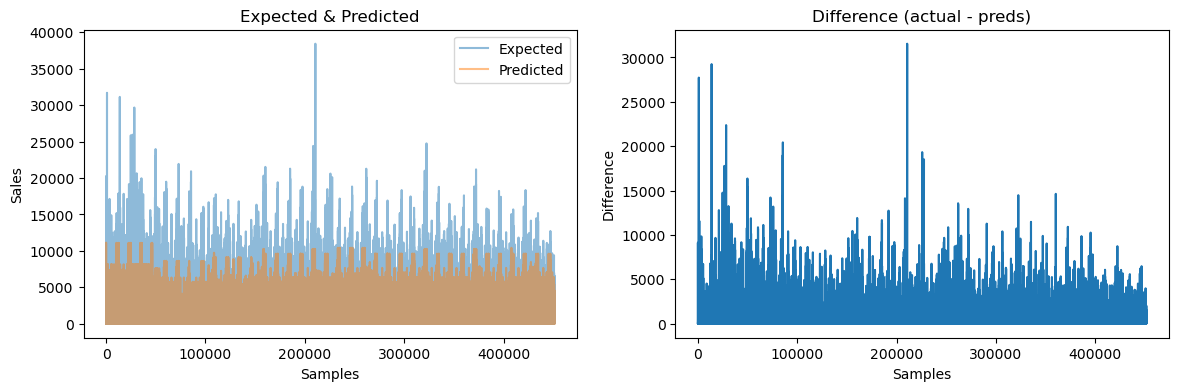

In [302]:
%matplotlib inline

def plot_predictions(nb_samples, actual, predictions):
    sp_list = list(range(0, nb_samples))

    plt.figure(figsize=FIGSIZE)
    plt.subplot(1, 2, 1)
    plt.plot(sp_list, actual, label='Expected', alpha=0.5)
    plt.plot(sp_list, predictions, label='Predicted', alpha=0.5)
    plt.legend(loc="upper right")
    plt.title('Expected & Predicted')
    plt.xlabel('Samples')
    plt.ylabel('Sales')

    plt.subplot(1, 2, 2)
    plt.plot(sp_list, abs(actual - predictions))
    plt.title('Difference (actual - preds)')
    plt.xlabel('Samples')
    plt.ylabel('Difference')

    plt.show()


plot_predictions(len(x_val), y_actual, y_pred)
plt.show()

In [303]:
feature_names = [x for x in train_df.columns if x not in drop_cols]
features_val = single_model.feature_importances_

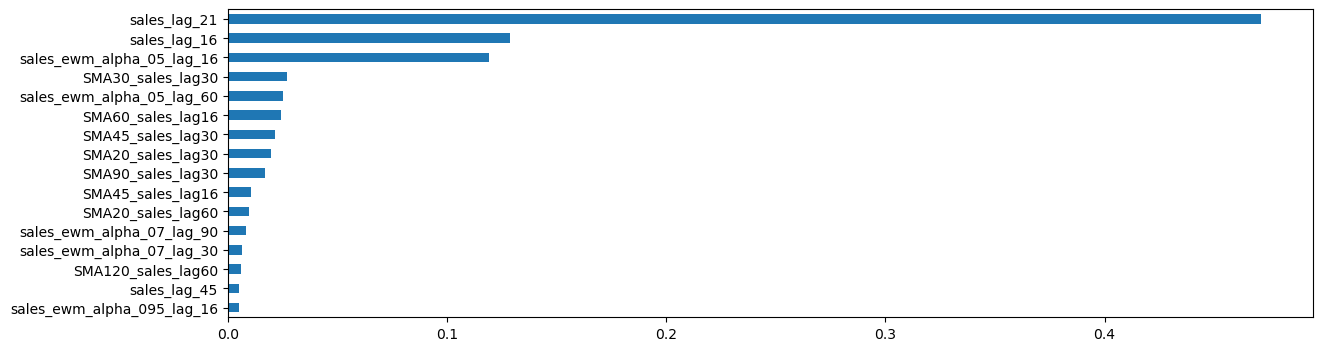

Features not shown
 ['SMA120_sales_lag16', 'SMA120_sales_lag30', 'SMA20_sales_lag16', 'SMA30_sales_lag16', 'SMA30_sales_lag60', 'SMA365_sales_lag16', 'SMA365_sales_lag30', 'SMA365_sales_lag60', 'SMA45_sales_lag60', 'SMA60_sales_lag30', 'SMA60_sales_lag60', 'SMA730_sales_lag16', 'SMA730_sales_lag30', 'SMA730_sales_lag60', 'SMA90_sales_lag16', 'SMA90_sales_lag60', 'city', 'cluster', 'day', 'dcoilwtico', 'earthquake', 'event_name', 'family', 'is_weekday', 'local_hname', 'month', 'month_end', 'national_hname', 'onpromotion', 'payday', 'regional_hname', 'sales_ewm_alpha_05_lag_30', 'sales_ewm_alpha_05_lag_90', 'sales_ewm_alpha_07_lag_16', 'sales_ewm_alpha_07_lag_60', 'sales_ewm_alpha_08_lag_16', 'sales_ewm_alpha_08_lag_30', 'sales_ewm_alpha_08_lag_60', 'sales_ewm_alpha_08_lag_90', 'sales_ewm_alpha_095_lag_30', 'sales_ewm_alpha_095_lag_60', 'sales_ewm_alpha_095_lag_90', 'sales_ewm_alpha_09_lag_16', 'sales_ewm_alpha_09_lag_30', 'sales_ewm_alpha_09_lag_60', 'sales_ewm_alpha_09_lag_90', 'sales_

In [304]:
plt.figure(figsize=FIGSIZE)
ft = pd.Series(features_val, index=feature_names)

nb_elem = 16
top_features = ft.nlargest(nb_elem, keep='all').sort_values(ascending=True)
top_features.plot.barh()

plt.show()

print('Features not shown\n', list(ft.index.difference(top_features.index)))

In [305]:
s_v = train_df['store_nbr'].unique()
shop_nbr = len(s_v)
shop_models = [None] * shop_nbr

shop_drop_cols = drop_cols.copy()
shop_drop_cols.append('store_nbr')

dropped_df = train_df.drop(shop_drop_cols, axis=1)
shop_features = dropped_df.columns

In [306]:
metrics_dict = {"mae": [], "mse": [], "rmsle": [], "r2": []}

for shop in range(shop_nbr):
    shop_df = train_df[train_df.store_nbr == shop]
    shop_y = np.log1p(shop_df['sales'])

    print(f"Training model {shop}...")
    shopmodel, x_val, y_val = train_model(shop_df[shop_features], shop_y)

    print(f"\nEvaluating sub-model {shop}")
    y_pred = shopmodel.predict(x_val)
    y_pred[y_pred < 0] = 0
    y_pred = np.expm1(y_pred)
    y_pred[y_pred < 0] = 0

    shop_models[shop] = shopmodel

    y_actual = np.expm1(y_val)
    show_metrics(y_actual, y_pred, metrics_dict)

Training model 0...
[0]	validation_0-rmse:2.75313
[1]	validation_0-rmse:1.97063
[2]	validation_0-rmse:1.42668
[3]	validation_0-rmse:1.06416
[4]	validation_0-rmse:0.83365
[5]	validation_0-rmse:0.68388
[6]	validation_0-rmse:0.59658
[7]	validation_0-rmse:0.54547
[8]	validation_0-rmse:0.51972
[9]	validation_0-rmse:0.50405
[10]	validation_0-rmse:0.49507
[11]	validation_0-rmse:0.49494
[12]	validation_0-rmse:0.49066
[13]	validation_0-rmse:0.49064
[14]	validation_0-rmse:0.49164
[15]	validation_0-rmse:0.49139
[16]	validation_0-rmse:0.49142
[17]	validation_0-rmse:0.49128
[18]	validation_0-rmse:0.49114
[19]	validation_0-rmse:0.49312
[20]	validation_0-rmse:0.49713
[21]	validation_0-rmse:0.49679
[22]	validation_0-rmse:0.50106
[23]	validation_0-rmse:0.50075
[24]	validation_0-rmse:0.50008
[25]	validation_0-rmse:0.50034
[26]	validation_0-rmse:0.50081
[27]	validation_0-rmse:0.49972
[28]	validation_0-rmse:0.50061
[29]	validation_0-rmse:0.50472
[30]	validation_0-rmse:0.50968
[31]	validation_0-rmse:0.5126

In [307]:
print(f"\nBy shop training summary")
for mkey, mval in metrics_dict.items():
    print("Average {} : {:.2f}".format(mkey.upper(), mean(mval)))


By shop training summary
Average MAE : 99.38
Average MSE : 242670.52
Average RMSLE : 0.46
Average R2 : 0.87


In [308]:
f_v = train_df['family'].unique()
family_nbr = len(f_v)
family_models = [None] * family_nbr

fam_drop_cols = drop_cols.copy()
fam_drop_cols.append('family')

dropped_df = train_df.drop(fam_drop_cols, axis=1)
fam_features = dropped_df.columns

In [309]:
metrics_dict = {"mae": [], "mse": [], "rmsle": [], "r2": []}

for fam in range(family_nbr):
    fam_df = train_df[train_df.family == fam]
    family_y = np.log1p(fam_df['sales'])

    print(f"Training model {fam}...")
    fammodel, x_val, y_val = train_model(fam_df[fam_features], family_y)

    print(f"\nEvaluating sub-model {fam}")
    y_pred = fammodel.predict(x_val)
    y_pred[y_pred < 0] = 0
    y_pred = np.expm1(y_pred)
    y_pred[y_pred < 0] = 0

    family_models[fam] = fammodel

    y_actual = np.expm1(y_val)
    show_metrics(y_actual, y_pred, metrics_dict)

Training model 0...
[0]	validation_0-rmse:1.17288
[1]	validation_0-rmse:0.90962
[2]	validation_0-rmse:0.74713
[3]	validation_0-rmse:0.65180
[4]	validation_0-rmse:0.59654
[5]	validation_0-rmse:0.56673
[6]	validation_0-rmse:0.55027
[7]	validation_0-rmse:0.54157
[8]	validation_0-rmse:0.53667
[9]	validation_0-rmse:0.53263
[10]	validation_0-rmse:0.52978
[11]	validation_0-rmse:0.52863
[12]	validation_0-rmse:0.52815
[13]	validation_0-rmse:0.52717
[14]	validation_0-rmse:0.52723
[15]	validation_0-rmse:0.52635
[16]	validation_0-rmse:0.52572
[17]	validation_0-rmse:0.52487
[18]	validation_0-rmse:0.52474
[19]	validation_0-rmse:0.52439
[20]	validation_0-rmse:0.52437
[21]	validation_0-rmse:0.52476
[22]	validation_0-rmse:0.52458
[23]	validation_0-rmse:0.52461
[24]	validation_0-rmse:0.52435
[25]	validation_0-rmse:0.52436
[26]	validation_0-rmse:0.52427
[27]	validation_0-rmse:0.52418
[28]	validation_0-rmse:0.52455
[29]	validation_0-rmse:0.52509
[30]	validation_0-rmse:0.52531
[31]	validation_0-rmse:0.5253

In [310]:
print(f"\nBy family training summary")
for mkey, mval in metrics_dict.items():
    print("Average {} : {:.2f}".format(mkey.upper(), mean(mval)))


By family training summary
Average MAE : 80.91
Average MSE : 127475.86
Average RMSLE : 0.31
Average R2 : 0.60


## Submissions

In [311]:
def make_predictions(s_model, test_data, features):
    pred_df = pd.DataFrame()
    id_df = pd.DataFrame()

    df = test_data[features]
    xgb_pred = pd.Series(s_model.predict(df, iteration_range=(0, s_model.best_iteration)))

    pred_df['sales'] = np.expm1(xgb_pred.map(lambda x: max(x, 0)))
    pred_df['sales'][pred_df['sales'] < 0] = 0

    id_df['id'] = test_data['id'].copy()
    id_df.reset_index(drop=True, inplace=True)
    pred_df['id'] = id_df['id']

    return pred_df

In [312]:
single_preds = make_predictions(single_model, test_df, single_features)

In [313]:
merged_df = pd.DataFrame()

for i in range(shop_nbr):
    preds_df = make_predictions(shop_models[i], test_df[test_df.store_nbr == i], shop_features)
    merged_df = pd.concat([merged_df, preds_df])

store_preds = merged_df.copy()
store_preds = store_preds.sort_values('id', ascending=True)
store_preds = store_preds.reset_index(drop=True)

In [314]:
merged_df = pd.DataFrame()

for i in range(family_nbr):
    preds_df = make_predictions(family_models[i], test_df[test_df.family == i], fam_features)
    merged_df = pd.concat([merged_df, preds_df])

family_preds = merged_df.copy()
family_preds = family_preds.sort_values('id', ascending=True)
family_preds = family_preds.reset_index(drop=True)

In [318]:
submission = single_preds  # or store_preds or single_preds
submission.to_csv('submission.csv', index=False)

print('Submission saved')


Submission saved
